<a href="https://colab.research.google.com/github/Gajabinkar-venkatesh/OCTANET_FEBRUARY/blob/main/Assigment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy xgboost joblib scikit-learn pymongo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 17.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

dining_df = pd.read_excel("/content/dining_info (2).xlsx")

# Convert relevant columns to datetime
dining_df['check_in_date'] = pd.to_datetime(dining_df['check_in_date'])
dining_df['check_out_date'] = pd.to_datetime(dining_df['check_out_date'])
dining_df['order_time'] = pd.to_datetime(dining_df['order_time'])

# Calculate stay duration and other features
dining_df['stay_duration'] = (dining_df['check_out_date'] - dining_df['check_in_date']).dt.days

# Extract customer-level features
customer_features = dining_df.groupby('customer_id').agg(
    total_orders_per_customer=('transaction_id', 'count'),
    avg_spend_per_customer=('price_for_1', 'mean'),
    total_qty_per_customer=('Qty', 'sum'),
    avg_stay_per_customer=('stay_duration', 'mean')
).reset_index()
customer_features.to_excel("customer_features.xlsx", index=False)


In [ ]:
# load and train model
train_df = dining_df[(dining_df['order_time'] >= "2024-01-01") & (dining_df['order_time'] <= "2024-10-01")]
train_df = train_df.merge(customer_features, on="customer_id", how="left")

# Drop unnecessary columns
train_df.drop(['transaction_id', 'customer_id', 'price_for_1', 'Qty', 'order_time'], axis=1, inplace=True)

# Encode categorical variables
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import joblib

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(train_df[['Preferred Cusine']])
joblib.dump(encoder, "encoder.pkl")

label_encoder = LabelEncoder()
train_df['dish'] = label_encoder.fit_transform(train_df['dish'])
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [ ]:
# train xg boost model
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import joblib

# Assuming X_train and y_train are already defined

# Convert 'Preferred Cusine' to numerical using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Create a new encoder instance
encoded_features = encoder.fit_transform(X_train[['Preferred Cusine']]) # Fit and transform on X_train
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Preferred Cusine'])) # Create a DataFrame from encoded features
X_train = X_train.drop(columns=['Preferred Cusine']) # Drop original 'Preferred Cusine' column
X_train = pd.concat([X_train, encoded_df], axis=1) # Concatenate encoded features

# Convert 'check_in_date' and 'check_out_date' to numerical features
# Example: Extract day of the week
X_train['check_in_dayofweek'] = X_train['check_in_date'].dt.dayofweek
X_train['check_out_dayofweek'] = X_train['check_out_date'].dt.dayofweek

# You can extract other features like month, year, etc. similarly.
# ...

# Drop original date columns
X_train.drop(['check_in_date', 'check_out_date'], axis=1, inplace=True)

# Now you can proceed with model training
model = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss")
model.fit(X_train, y_train)
joblib.dump(model, "xgb_model_dining.pkl")

['xgb_model_dining.pkl']

In [ ]:
from joblib import load
model = load("xgb_model_dining.pkl")
encoder = load("encoder.pkl")
label_encoder = load("label_encoder.pkl")


In [ ]:
real_time_data = pd.DataFrame([{
    'Preferred Cusine': 'North Indian',
    'check_in_date': '2025-03-10',
    'check_out_date': '2025-03-12',
    'age': 30,
    'stay_duration': 2
}])

# Convert 'check_in_date'


In [ ]:
# model performance
# model performance
test_df = dining_df[dining_df['order_time'] > "2024-10-01"]
X_test = test_df.drop(columns=['dish'])

# Apply the same preprocessing steps as during training
# 1. Encode 'Preferred Cusine' using the loaded encoder
encoded_features = encoder.transform(X_test[['Preferred Cusine']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Preferred Cusine']))
X_test = X_test.drop(columns=['Preferred Cusine'])
X_test = pd.concat([X_test, encoded_df], axis=1)

# 2. Convert 'check_in_date' and 'check_out

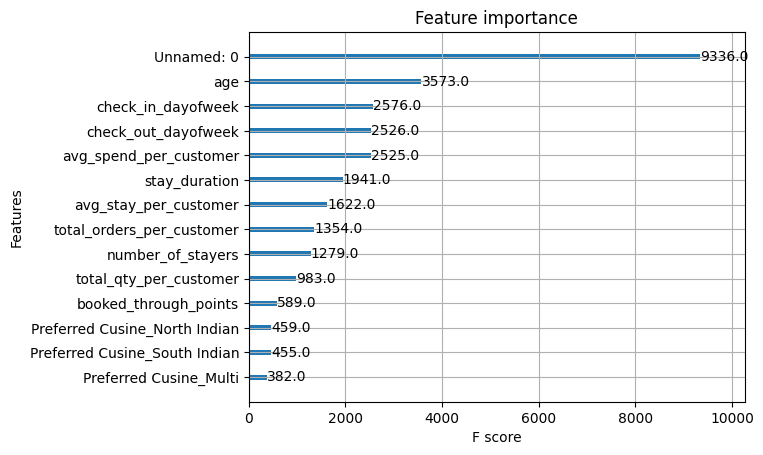

In [ ]:
# visualization and report
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.show()
